# Polymer dynamics with varying temperature and forces

First run the example to train and save the trained model
```shell
cd ./examples/polymer_dynamics
python polymer_dynamics_temperature.py --config-name polymer_dynamics_temperature_Fs.yaml
```

The results will be saved to a path in `./outputs/...` that appropriately time-stamped.

The rest of the notebook will perform analysis on the outputs.

In [1]:
import os
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
from tqdm import tqdm

## Read saved model and config

In [2]:
from omegaconf import OmegaConf
from polymer_dynamics_temperature import build_model, log_transform
from datasets import load_dataset

In [3]:
path = "outputs/2025_03_28-17_07_36"
config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
model_template = build_model(config)
trained_model = eqx.tree_deserialise_leaves(os.path.join(path, "model.eqx"), model_template)

## Predictions

We first test the predictions of the mean, standard deviation and the unfolding time distribution.

Load test data

In [4]:
test_data = load_dataset("MLDS-NUS/Fs_Validation_Reduced").with_format("numpy")

In [5]:
test_data = log_transform(test_data).with_format("numpy")

In [6]:
from examples.utils.sde import SDEIntegrator
integrator = SDEIntegrator(model=trained_model, state_dim=config.dim)

Helper functions

In [7]:
@jax.jit
def compute_unfolding_time(traj):
    unfolded_extension = traj[:, -1, 0]
    threshold = 0.95 * unfolded_extension
    first_index = jnp.argmin(traj[:, :, 0] <= threshold[:, None], axis=1)
    return first_index

In [8]:
def compare_statistics(test_split, key):

    # Extract data
    test_data_fast = test_data[f"{test_split}_fast"]
    test_data_medium = test_data[f"{test_split}_middle"]
    test_data_slow = test_data[f"{test_split}_slow"]
    test_x = [test_data_fast["x"], test_data_medium["x"], test_data_slow["x"]]
    test_args = [test_data_fast["args"][0,0], test_data_medium["args"][0,0], test_data_slow["args"][0,0]]

    # Generate predicted trajectories
    num_runs = test_data_fast.shape[0]
    keys = jr.split(key, 3)
    predicted_trajectories = []
    for key, traj, args in zip(keys, test_x, test_args):
        init_conditions = jnp.repeat(traj[0, 0, :][None, :], num_runs, axis=0)
        bm_keys = jr.split(key, num_runs)
        sol = integrator.parallel_solve(
            key=bm_keys,
            initial_conditions=init_conditions,
            t0=0.0,
            t1=config.dt * test_x[0].shape[1],
            dt=config.dt,
            args=args,
        )
        predicted_trajectories.append(sol.ys)

    # Compute statistics
    fig, ax = plt.subplots(3, 3, figsize=(12, 8), layout="constrained")
    for a, true, pred in zip(ax, test_x, predicted_trajectories):
        true_mean = jnp.mean(true, axis=0)
        pred_mean = jnp.mean(pred, axis=0)

        a[0].plot(true_mean[:, 0], label="True")
        a[0].plot(pred_mean[:, 0], label="Pred")
        a[0].set_title("Mean")

        true_std = jnp.std(true, axis=0)
        pred_std = jnp.std(pred, axis=0)

        a[1].plot(true_std[:, 0], label="True")
        a[1].plot(pred_std[:, 0], label="Pred")
        a[1].set_title("Standard deviation")

        true_unfolding_time = compute_unfolding_time(true)
        pred_unfolding_time = compute_unfolding_time(pred)

        a[2].hist(true_unfolding_time, label="True", alpha=0.5, density=True, bins=20)
        a[2].hist(pred_unfolding_time, label="Pred", alpha=0.5, density=True, bins=20)
        a[2].set_title("Unfolding time")

    for a in ax.flatten():
        a.set_xlabel(r"$t$")

    for a, label in zip(ax[:, 0], ["Fast", "Medium", "Slow"]):
        a.set_ylabel(label)

    fig.suptitle(f"Comparison of Statistics for {test_split}", fontsize=16)

Compare statistics

In [9]:
unique_labels = set(k.rsplit('_', 1)[0] for k in test_data.keys())
print(unique_labels)

{'F23_10_T1', 'F2_78_T1', 'F16_20_T1', 'F1_62_T1', 'F2_31_T1', 'F3_93_T1', 'F4_63_T1', 'F11_60_T1'}


8it [03:53, 29.25s/it]


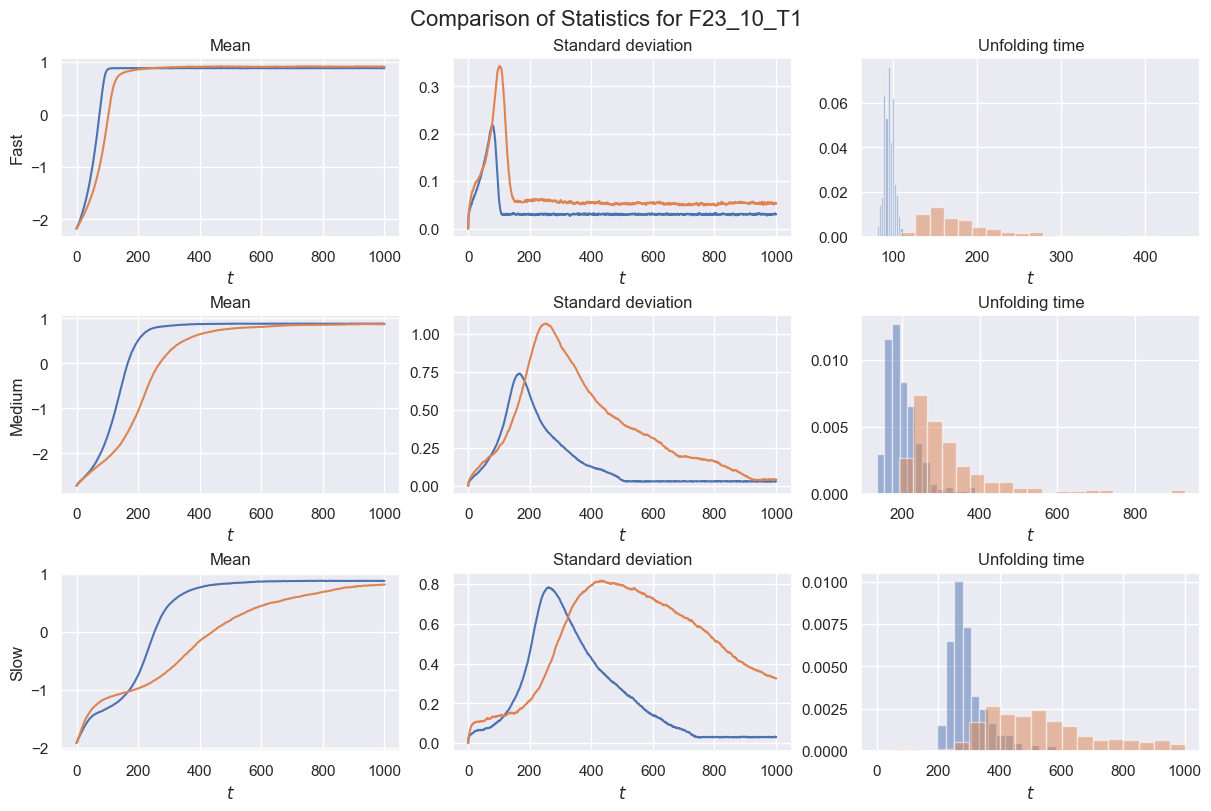

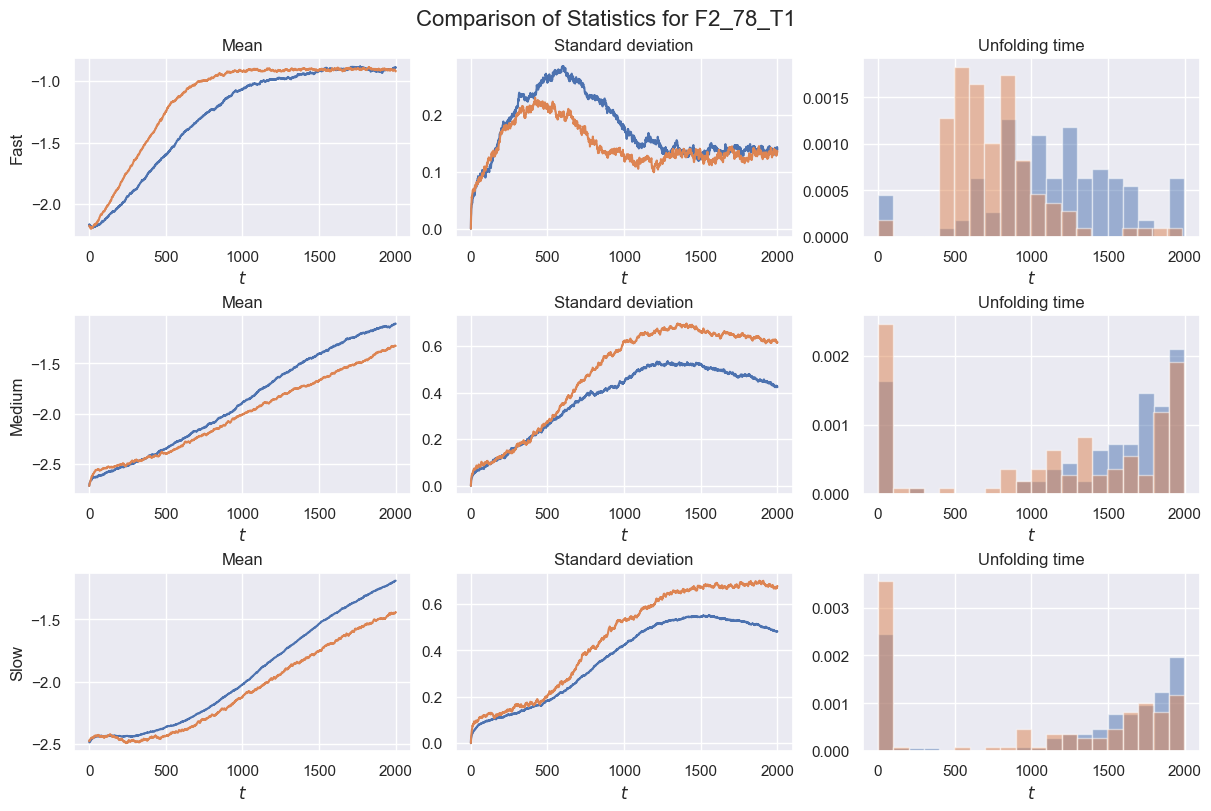

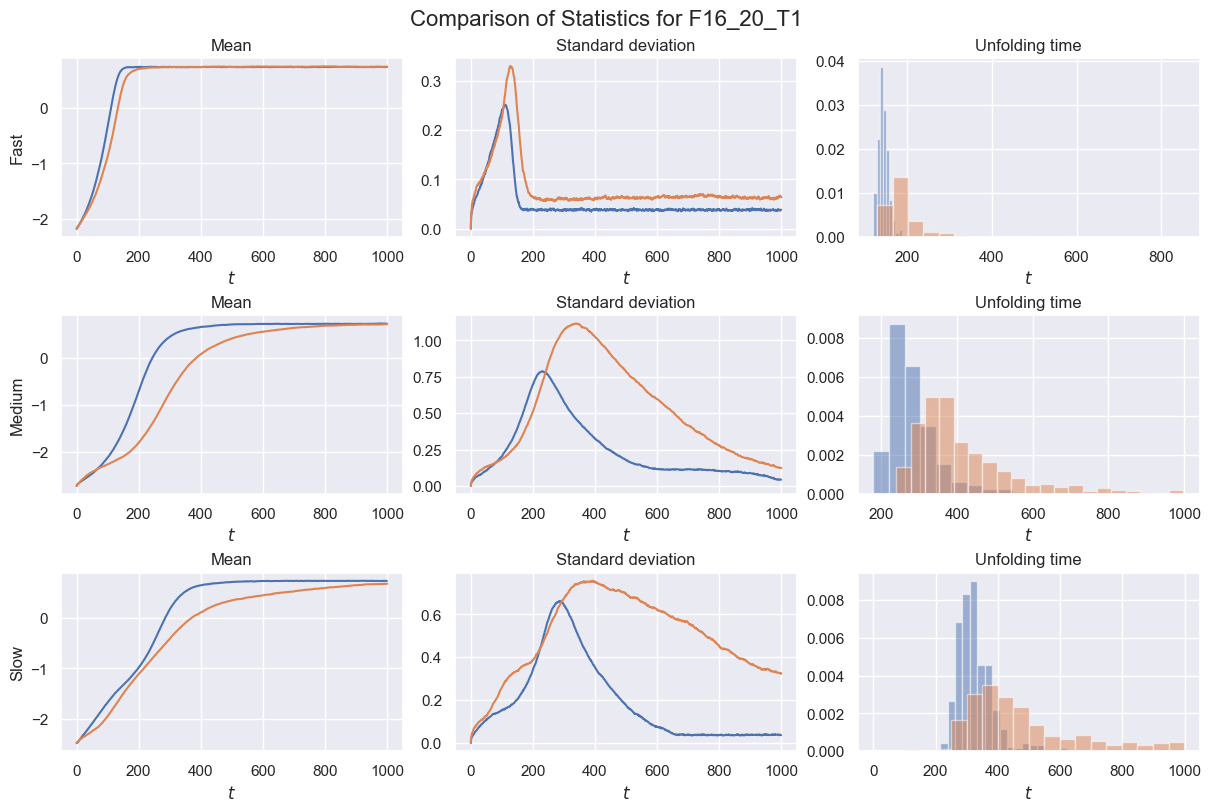

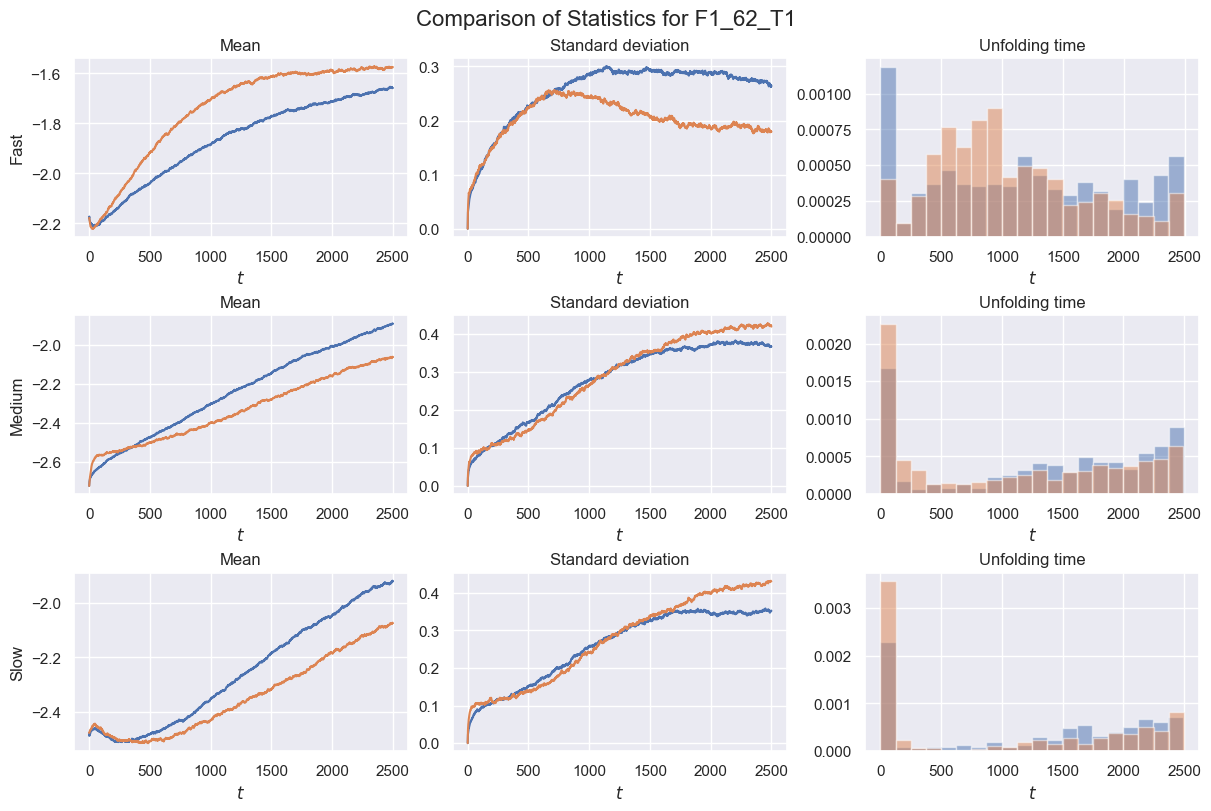

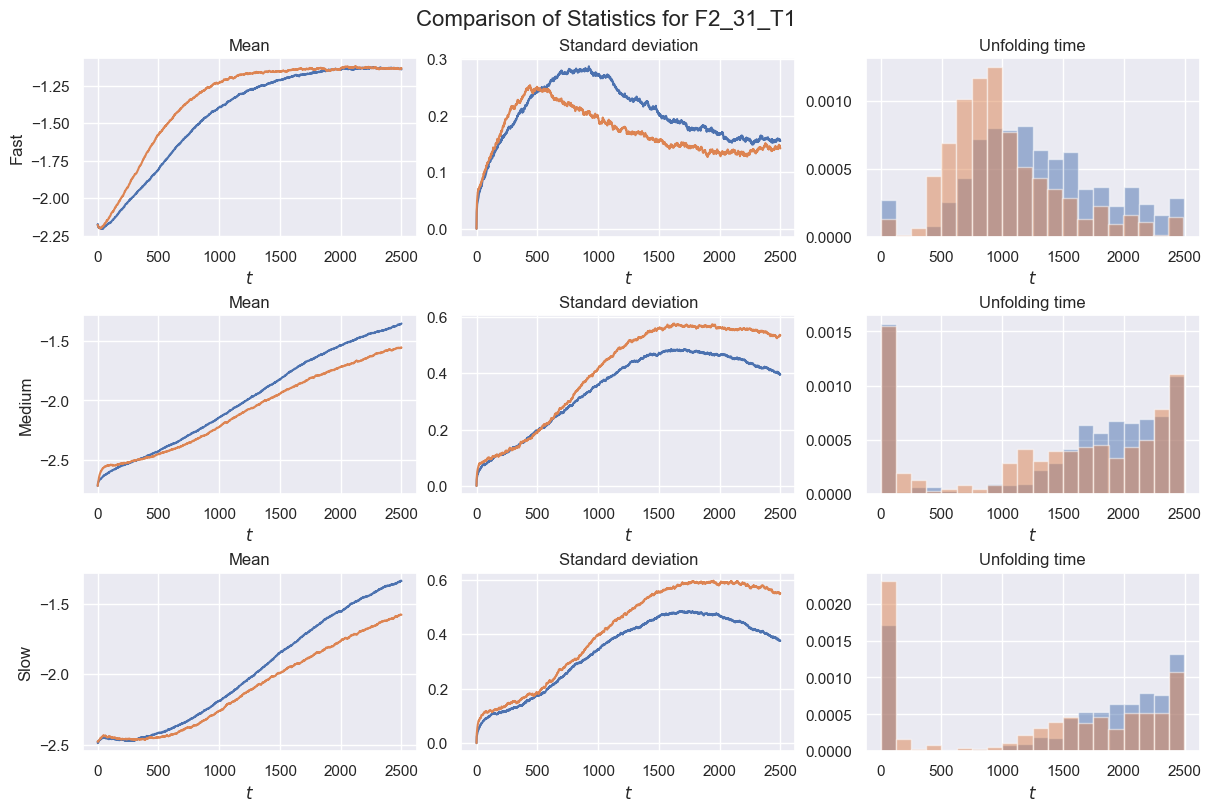

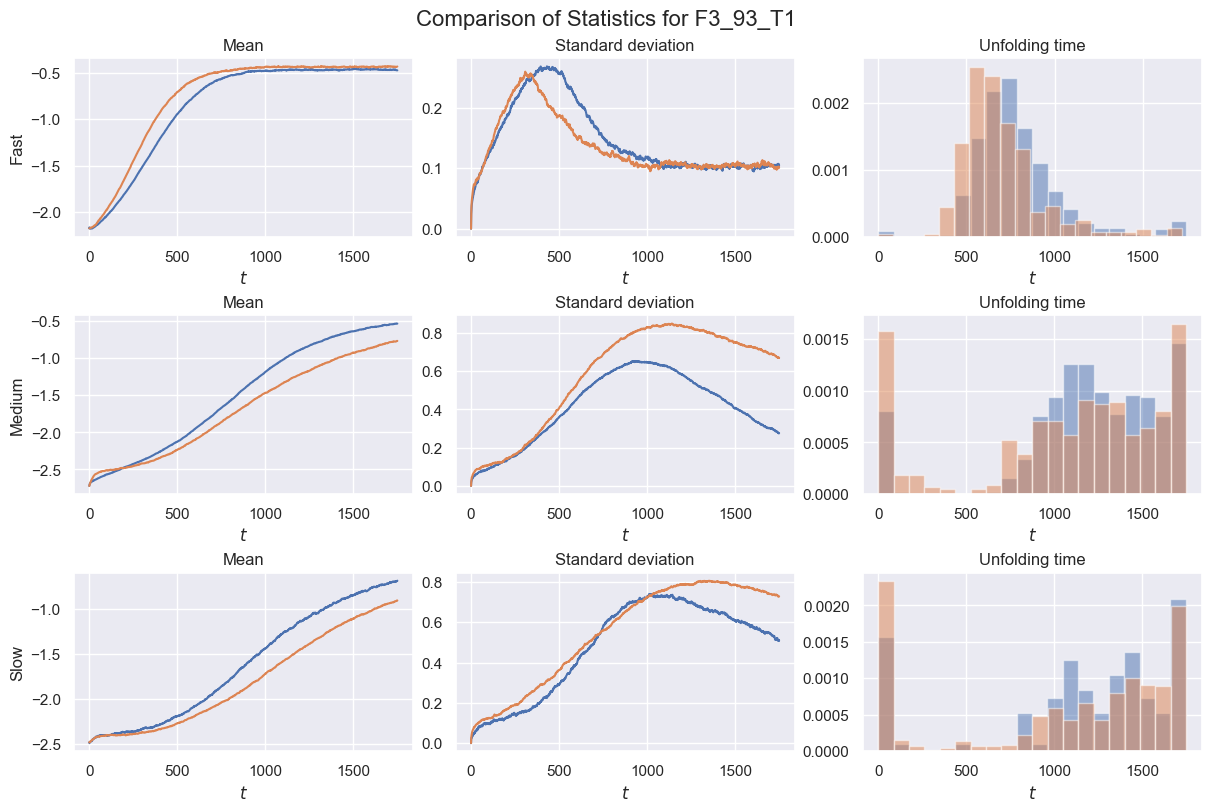

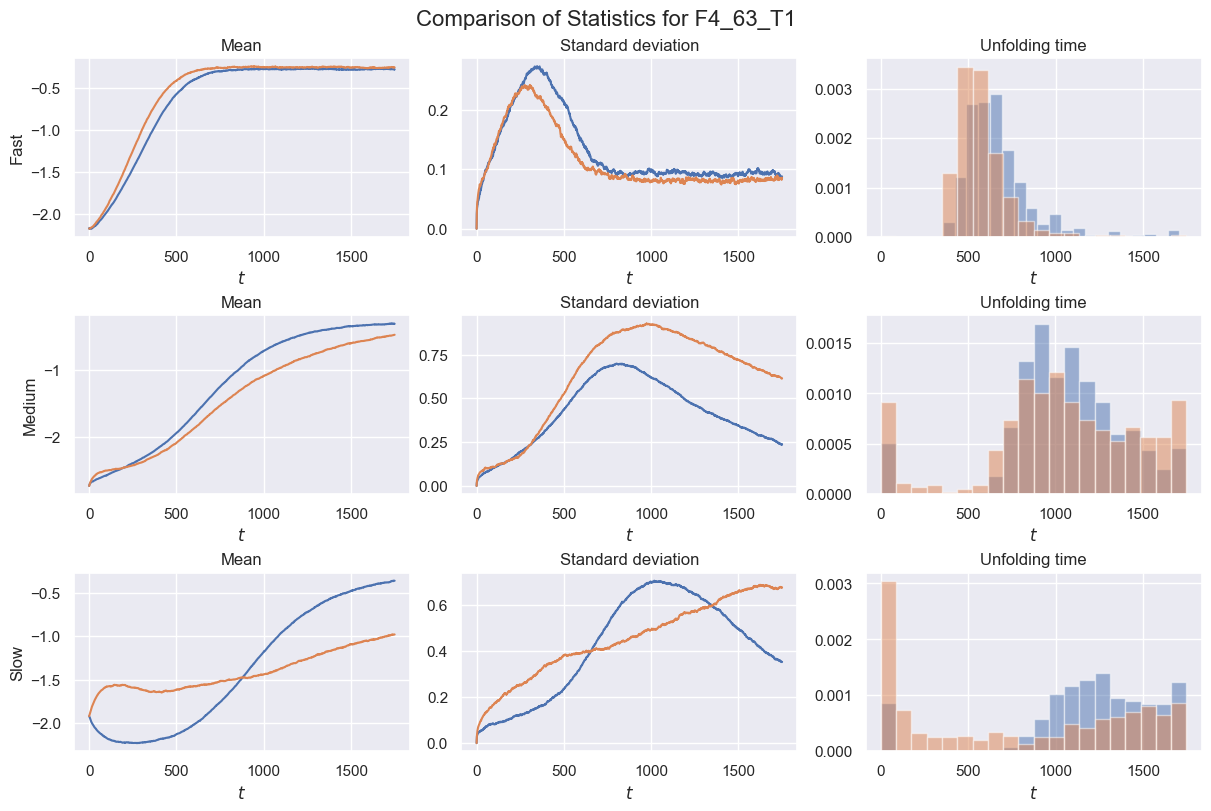

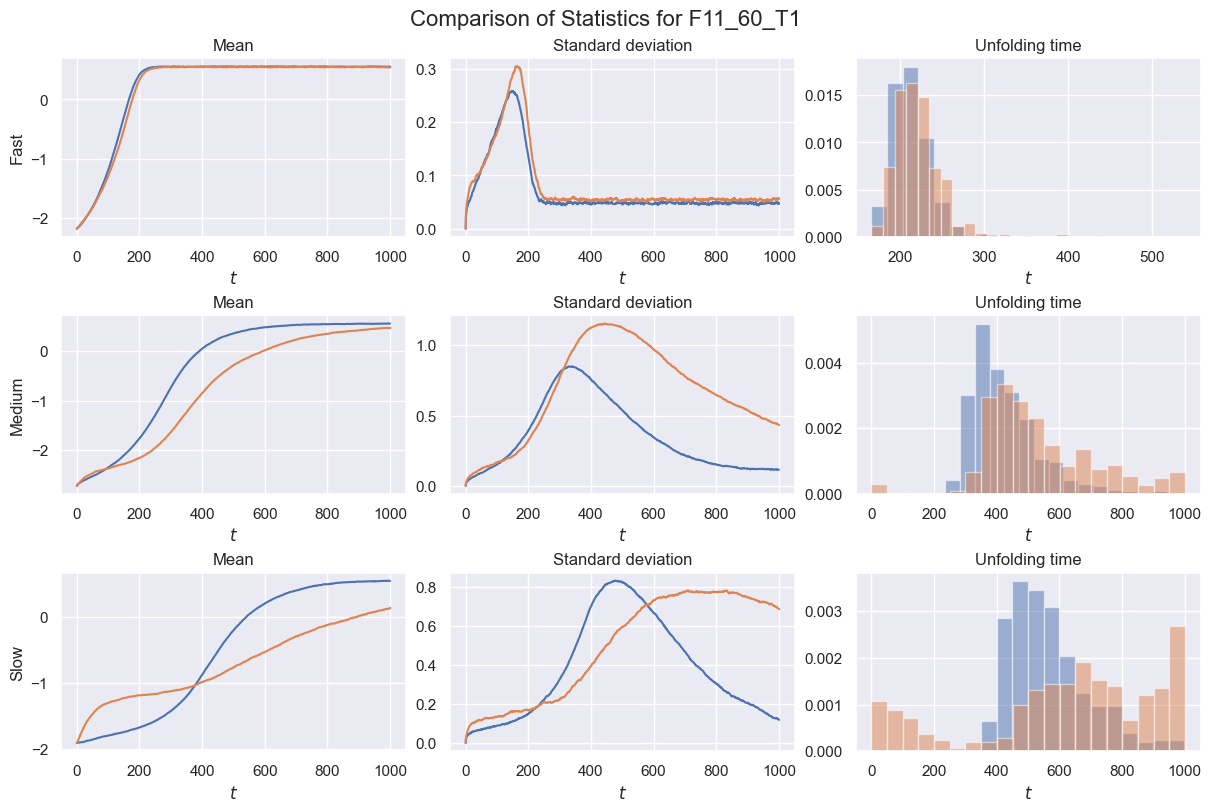

In [10]:
test_splits = set(k.rsplit('_', 1)[0] for k in test_data.keys())  # all splits
keys = jr.split(jr.PRNGKey(config.model.seed + 123), len(test_splits))

for key, test_split in tqdm(zip(keys, test_splits)):
    compare_statistics(test_split, key)

## Potential landscape

Next, let us compare the potential landscape.

As described in the paper, we will visualise 2D projections of the 3D potential defined by
$$
    v(z_1, z_2) := \inf_{z_3} V(z_1, z_2, z_3)
$$
We know from large deviations theory that for sufficiently low temperatures, this approximation is valid.

In [11]:
# z1_min, z1_max = -3, 1
# z2_min, z2_max = -2, 2
# z3_min, z3_max = -6, 6
# num_samples_aux_dimension = 128  # number of samples to take infimum over

In [12]:
# def V(z1, z2, z3):
#     z = jnp.array([z1, z2, z3])
#     return trained_model.potential(z, jnp.array([test_T, test_Wi/10.0]))

In [13]:
# @jax.vmap
# @jax.jit
# def V_12(z1, z2):
#     z3_test_range = jnp.linspace(z3_min, z3_max, num_samples_aux_dimension)
#     return jnp.min(jax.vmap(V, (None, None, 0))(z1, z2, z3_test_range))

# @jax.vmap
# @jax.jit
# def V_13(z1, z3):
#     z2_test_range = jnp.linspace(z2_min, z2_max, num_samples_aux_dimension)
#     return jnp.min(jax.vmap(V, (None, 0, None))(z1, z2_test_range, z3))

# @jax.vmap
# @jax.jit
# def V_23(z2, z3):
#     z1_test_range = jnp.linspace(z1_min, z1_max, num_samples_aux_dimension)
#     return jnp.min(jax.vmap(V, (0, None, None))(z1_test_range, z2, z3))

In [14]:
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# num_grid = 100
# num_levels = 50
# off_set = 1.0
# level_start = 0.0
# level_end = 500.0

# custom_levels = jnp.linspace(level_start, level_end, num_levels)

# # Define the range and number of points in each dimension
# z1_range = jnp.linspace(z1_min - off_set, z1_max + off_set, num_grid)
# z2_range = jnp.linspace(z2_min - off_set, z2_max + off_set, num_grid)
# z3_range = jnp.linspace(z3_min - off_set, z3_max + off_set, num_grid)

# # V12
# Z1, Z2 = jnp.meshgrid(z1_range, z2_range)
# V12_grid = V_12(Z1.ravel(), Z2.ravel()).reshape(Z1.shape)
# contour1 = ax[0].contour(Z1, Z2, V12_grid, levels=custom_levels)
# ax[0].set_title(r'$V_{12}$')
# ax[0].set_xlabel(r'$Z_1$')
# ax[0].set_ylabel(r'$Z_2$')

# # V13
# Z1, Z3 = jnp.meshgrid(z1_range, z3_range)
# V13_grid = V_13(Z1.ravel(), Z3.ravel()).reshape(Z1.shape)
# contour2 = ax[1].contour(Z1, Z3, V13_grid, levels=custom_levels)
# ax[1].set_title(r'$V_{13}$')
# ax[1].set_xlabel(r'$Z_1$')
# ax[1].set_ylabel(r'$Z_3$')

# # V23
# Z2, Z3 = jnp.meshgrid(z2_range, z3_range)
# V23_grid = V_23(Z2.ravel(), Z3.ravel()).reshape(Z1.shape)
# contour3 = ax[2].contour(Z2, Z3, V23_grid, levels=custom_levels)
# ax[2].set_title(r'$V_{23}$')
# ax[2].set_xlabel(r'$Z_2$')
# ax[2].set_ylabel(r'$Z_3$')

# cbar = fig.colorbar(contour3, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)